In [17]:
import os
from os import listdir
import pandas as pd
import datetime

In [18]:
# file paths

# raw data path
raw_path = '../../data/TSLA/RawData/'
# processed data path
data_path = '../../data/TSLA/ProcData'
# merged filtered file name
merged_data = 'merge_filter_data.csv'
# feature engineered file name
feat_data = 'feat_eng_data.csv'
# data with time + volatility
vol_data = 'data_vol.csv'
label_data = 'label.csv'

Merge and Preprocess raw data

In [19]:
# obtain needed data for processing
# Filter out data to use volatility on data an hour prior to market open
# Market Open: NYSE open Monday-Friday 9:30am to 4pm. Eastern time
def raw_to_data(fp):
    
    # read in data
    data = pd.read_csv(fp)
    # convert time column time zone
    data.time = pd.DatetimeIndex(data.time).tz_localize('US/Eastern')
    # filter out data for use
    market_open_time = datetime.time(hour=9, minute=30)
    market_1hr_early = datetime.time(hour=8, minute=30)
    data = data.loc[data.time.apply(lambda date:(date.time()<=market_open_time)
                        and (date.time()>=market_1hr_early)
                        )]
    data.reset_index(drop=True, inplace=True)
    
    return data

In [20]:
# obtain needed data for processing
# Filter out data to use volatility on data an hour prior to market open
# Market Open: NYSE open Monday-Friday 9:30am to 4pm. Eastern time
def raw_to_data_market(fp):
    
    # read in data
    data = pd.read_csv(fp)
    # convert time column time zone
    data.time = pd.DatetimeIndex(data.time).tz_localize('US/Eastern')
    # filter out data for use
    market_open_time = datetime.time(hour=9, minute=30)
    market_close_time = datetime.time(hour=16, minute=0)
    data = data.loc[data.time.apply(lambda date:(date.time()<=market_close_time)
                        and (date.time()>=market_open_time)
                        )]
    data.reset_index(drop=True, inplace=True)
    
    return data

In [21]:
# merge processed files from raw path to data path
def merge_data(raw_path):
    
    # output dataframe
    output = pd.DataFrame()
    # all files to be processed
    raw_files = listdir(raw_path)
    
    for curr_file in raw_files:
        fp = raw_path + curr_file
        data = raw_to_data(fp)
        output = pd.concat([output, data])
    
    return output

In [22]:
# merge processed files from raw path to data path
def merge_data_market(raw_path):
    
    # output dataframe
    output = pd.DataFrame()
    # all files to be processed
    raw_files = listdir(raw_path)
    
    for curr_file in raw_files:
        fp = raw_path + curr_file
        data = raw_to_data_market(fp)
        output = pd.concat([output, data])
    
    return output

In [23]:
data = merge_data(raw_path)
data_market = merge_data_market(raw_path)
# data.to_csv(data_path+'/'+merged_data, index=False)

In [24]:
# data = pd.read_csv(data_path+'/'+merged_data, parse_dates=['time'])

Feature Engineer preprocessed data for volatility analysis

In [25]:
def feature_engineer(data, time_wdw):
    
    # for time series indexing
    data.set_index('time', inplace=True)
    
    # High-Low within minute bar
    data['diff'] = data.high-data.low
    # Volitility Analysis
    vol = data['diff'].rolling(time_wdw).mean()
    data = data.assign(Volatility=vol)
    # for modelling purpose
    data.dropna(axis=0, inplace=True)
    data.reset_index(inplace = True)
    
    return data

In [26]:
data = feature_engineer(data, 5)
data_market = feature_engineer(data_market, 5)

# data.to_csv(data_path+'/'+feat_data, index=False)

In [27]:
data_market

,time,open,high,low,close,volume,diff,Volatility
0,2020-06-22 15:56:00-04:00,198.716,198.83100,198.702,198.76600,104250,0.12900,0.215000
1,2020-06-22 15:55:00-04:00,198.848,198.89800,198.676,198.74150,90950,0.22200,0.223400
2,2020-06-22 15:54:00-04:00,198.820,198.88000,198.662,198.85000,107475,0.21800,0.220200
3,2020-06-22 15:53:00-04:00,198.888,198.90400,198.700,198.79000,120905,0.20400,0.207400
4,2020-06-22 15:52:00-04:00,199.028,199.04600,198.838,198.90200,88935,0.20800,0.196200
...,...,...,...,...,...,...,...,...
192912,2019-07-29 09:34:00-04:00,45.600,45.60000,45.340,45.36844,254885,0.26000,0.191856
192913,2019-07-29 09:33:00-04:00,45.648,45.71998,45.556,45.60000,227410,0.16398,0.192940
192914,2019-07-29 09:32:00-04:00,45.590,45.74800,45.560,45.61800,256310,0.18800,0.191740
192915,2019-07-29 09:31:00-04:00,45.418,45.68000,45.416,45.59670,798630,0.26400,0.218940


Date and Volatility Column for Further Inspection

In [28]:
data = pd.read_csv(data_path+'/'+feat_data, parse_dates=['time'])
data.head()

,time,open,high,low,close,volume,diff,Volatility
0,2021-01-15 09:26:00-05:00,852.98,853.25,852.98,853.25,3460,0.27,1.20796
1,2021-01-15 09:25:00-05:00,852.75,853.00,852.75,852.85,4066,0.25,0.52396
2,2021-01-15 09:24:00-05:00,853.20,853.20,852.50,852.80,5050,0.70,0.36396
3,2021-01-15 09:23:00-05:00,853.43,853.45,853.25,853.25,3859,0.20,0.31396
4,2021-01-15 09:22:00-05:00,853.50,853.50,853.50,853.50,1805,0.00,0.28400


In [30]:
data = data.assign(date=data.time.apply(lambda x:x.date()))
data.head()
#data = data[['date','Volatility']]
# data.to_csv(data_path+'/'+vol_data, index=False)

,time,open,high,low,close,volume,diff,Volatility,date
0,2021-01-15 09:26:00-05:00,852.98,853.25,852.98,853.25,3460,0.27,1.20796,2021-01-15
1,2021-01-15 09:25:00-05:00,852.75,853.00,852.75,852.85,4066,0.25,0.52396,2021-01-15
2,2021-01-15 09:24:00-05:00,853.20,853.20,852.50,852.80,5050,0.70,0.36396,2021-01-15
3,2021-01-15 09:23:00-05:00,853.43,853.45,853.25,853.25,3859,0.20,0.31396,2021-01-15
4,2021-01-15 09:22:00-05:00,853.50,853.50,853.50,853.50,1805,0.00,0.28400,2021-01-15


### Create Lables = Mean Volatility before and after Market Open

In [31]:
before_vol = data[['date','Volatility']]
before_vol_mean = before_vol.groupby('date')['Volatility'].mean()
before_vol_mean = pd.DataFrame(before_vol_mean)
before_vol_mean.rename(columns={"Volatility":"Mean Vol Before Open"},inplace=True)
before_vol_mean.head()

,Mean Vol Before Open
date,
2019-01-30,0.019796
2019-01-31,0.059639
2019-02-01,0.020399
2019-02-04,0.032916
2019-02-05,0.010686


In [32]:
after_vol = data_market.assign(date=data_market.time.apply(lambda x:x.date()))
after_vol = after_vol[['date','Volatility']]
after_vol_mean = after_vol.groupby('date')['Volatility'].mean()
after_vol_mean = pd.DataFrame(after_vol_mean)
after_vol_mean.rename(columns={"Volatility":"Mean Vol After Open"},inplace=True)
after_vol_mean.head()

,Mean Vol After Open
date,
2019-01-30,0.089144
2019-01-31,0.126792
2019-02-01,0.089911
2019-02-04,0.096607
2019-02-05,0.074881


In [33]:
combined = before_vol_mean.merge(after_vol_mean, left_on='date', right_on='date')
combined.head()

,Mean Vol Before Open,Mean Vol After Open
date,,
2019-01-30,0.019796,0.089144
2019-01-31,0.059639,0.126792
2019-02-01,0.020399,0.089911
2019-02-04,0.032916,0.096607
2019-02-05,0.010686,0.074881


In [34]:
combined['score'] = combined['Mean Vol After Open']/combined['Mean Vol Before Open']
combined.head()

,Mean Vol Before Open,Mean Vol After Open,score
date,,,
2019-01-30,0.019796,0.089144,4.503171
2019-01-31,0.059639,0.126792,2.125986
2019-02-01,0.020399,0.089911,4.407548
2019-02-04,0.032916,0.096607,2.934941
2019-02-05,0.010686,0.074881,7.007146


In [35]:
combined.score.describe()

count    496.000000
mean       3.395103
std        3.345803
min        0.348782
25%        1.907474
50%        2.718171
75%        3.938933
max       60.851223
Name: score, dtype: float64

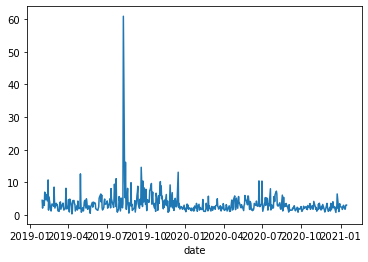

In [36]:
combined.score.plot()

In [56]:
combined['percentile'] = combined.score.rank(pct = True)
combined['Percentile Class'] = combined.percentile//0.1
combined['Percentile Class'] = combined['Percentile Class'].astype(int).astype(str)
combined.head()

,Mean Vol Before Open,Mean Vol After Open,score,percentile,Percentile Class
date,,,,,
2019-01-30,0.019796,0.089144,4.503171,0.824597,8
2019-01-31,0.059639,0.126792,2.125986,0.322581,3
2019-02-01,0.020399,0.089911,4.407548,0.810484,8
2019-02-04,0.032916,0.096607,2.934941,0.562500,5
2019-02-05,0.010686,0.074881,7.007146,0.941532,9


In [57]:
combined.to_csv(data_path+'/'+label_data, index=True)